In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import *
from numba import jit

from velocity_models import constant_velocity
from seismic_wavelets import ricker_wavelet
from data_plotting import plotting_seismic_signal

In [2]:
h = 10.0                                       # espaçamento da malha (metros)
dt = 0.0005                                    # taxa de variação temporal (segundos)
dimX = 300                                     # extensão do domínio
dimZ = 200                                     # profundidade do domínio
Ntotal = 3000                                  # tempo total discreto
cut_frequency = 30                             # frequencia de corte


# posicionamento fonte sísmica
shot_x = 150
shot_z = 5
# posicionamento receptores
rec_x = 150
rec_z = 100        

In [3]:
seismic_source       = np.zeros(Ntotal)            # fonte sísmica
velocity             = np.zeros((dimZ, dimX))      # campo de velocidades
C                    = np.zeros((dimZ, dimX))      # matriz auxilar
    
wavefield01          = np.zeros((dimZ, dimX))      # campo de pressão em n - dt
wavefield02          = np.zeros((dimZ, dimX))      # campo de pressão em n
wavefield03          = np.zeros((dimZ, dimX))      # campo de pressão em n + dt

seismic_signal       = np.zeros(Ntotal)         # sinal sísmico em 1 receptor

In [4]:
# definindo campo de velocidades
velocity = constant_velocity(1500.0, dimX, dimZ)

# definindo a fonte sismica (ricker)
seismic_source = ricker_wavelet(cut_frequency, dt, Ntotal)

In [5]:
# coeficiente de diferencas finitas
c = (-2.0, 1.0)

# matriz auxiliar Cik
for i in range(dimZ):
    for k in range(dimX):
        C[i, k] = (velocity[i, k] * (dt/h)) ** 2

In [6]:
@jit  # Compilador Just-in-time
def seismic_modeling(wavefield01, wavefield02, wavefield03, 
                     C, c, seismic_source, shot_x, shot_z, Ntotal, rec_x, rec_z, seismic_signal):
    
    for n in range(0,Ntotal):

        # Cálculo do Campo no interior do modelo
        for i in range(1, dimZ-1):
            for k in range(1, dimX-1):

                wavefield03[i,k] = C[i,k] * (2.0*c[0]*wavefield02[i, k] + c[1]*(wavefield02[i,k-1] + wavefield02[i,k+1]+ wavefield02[i-1,k] + wavefield02[i+1,k])) + 2.0*wavefield02[i,k] - wavefield01[i,k]

        # Termo fonte
        wavefield02[shot_z,shot_x] = wavefield02[shot_z,shot_x] + seismic_source[n]*(velocity[shot_z,shot_x]**2)
        
        
        seismic_signal[n] = wavefield02[rec_z,rec_x]
        
        #for k in range (dimX):
        #    sis[n, k] = wavefield03[rec_z,k]

        # Atualização do campo de onda
        wavefield01 = np.copy(wavefield02)
        wavefield02 = np.copy(wavefield03)

        if n % 1000 == 0:
            print(n)

C:\Users\chsba\AppData\Local\Temp\ipykernel_12436\2549636036.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def seismic_modeling(wavefield01, wavefield02, wavefield03,


In [7]:
seismic_modeling(wavefield01, wavefield02, wavefield03, 
                 C, c, seismic_source, shot_x, shot_z, Ntotal, rec_x, rec_z, seismic_signal)

0
1000
2000


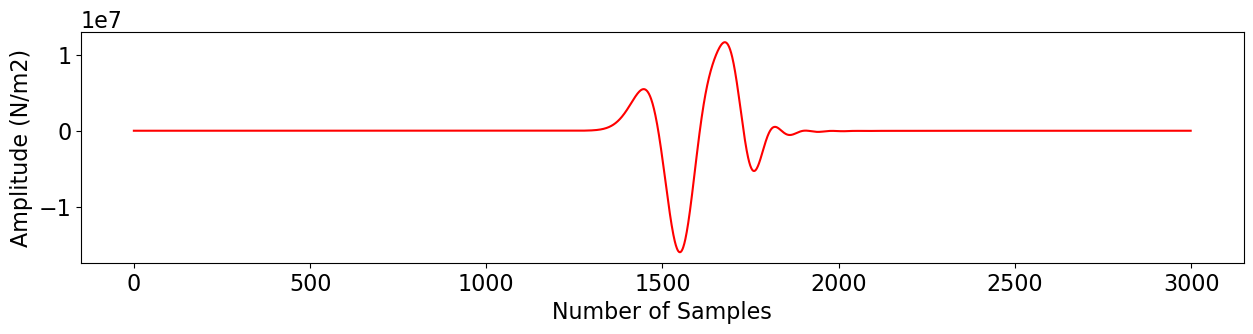

In [8]:
image_name = "seismic_signal_2nd.png"
plotting_seismic_signal(seismic_signal, image_name)